In [1]:
using LinearAlgebra
using Plots

push!(LOAD_PATH,".")
using SBP_operators

["@", "@v#.#", "@stdlib", "."]



(process:38748): GLib-GIO-WARNING **: 20:22:59.771: Unexpectedly, UWP app `Microsoft.WindowsDVDPlayer_3.6.13291.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.WindowsDVDPlayer_8wekyb3d8bbwe!Microsoft.WindowsDVDPlayer') supports 1 extensions but has no verbs


Construct the grid using the SBP_operators package

In [11]:
#=== Problem setup ===#
𝒟x = [0.0,1.0]
𝒟y = [0.0,1.0]
nx = 41
ny = 41
Dom = Grid2D(𝒟x,𝒟y,nx,ny)

Δt = 0.1* min(Dom.Δx^2,Dom.Δy^2)
t_f = 100Δt


0.006250000000000001

Define the things we need for the solution with the MMS

$$
    \tilde{F}(x,y) = \sin(2\pi\omega_x x + c_x)\sin(2\pi\omega_y y + c_y)
$$
and then choose the solution
$$
    \tilde{u}(x,y,t) = \cos(2\pi t)\tilde{F}(x,y)
$$


In [16]:
cx = cy = 0.0
K = 1.0
ωx = ωy = 1.0


ũ(x,y,t) = cos(2π*t) * sin(2π*x + cx) * sin(2π*y + cy) #Solution

ũ₀(x,y) = sin(2π*x + cx) * sin(2π*y + cy) #Initial condition

Bxũ(y,t) = 0.0 #cos(2π*t) * sin(cx) * sin(2π*y + cy) #Boundary condition x
Byũ(x,t) = 0.0 #cos(2π*t) * sin(2π*x + cx) * sin(cy) #Boundary condition y

F(x,y,t) = -2π*sin(2π*t)*sin(2π*x+cx)*sin(2π*y+cy) - 
    K * 4π^2 * (ωx^2 + ωy^2) * cos(2π*t)*sin(2π*x+cx)*sin(2π*y+cy) #F = ∂ₜũ - K∇ũ 



F (generic function with 1 method)

Plot the solution at the final time step

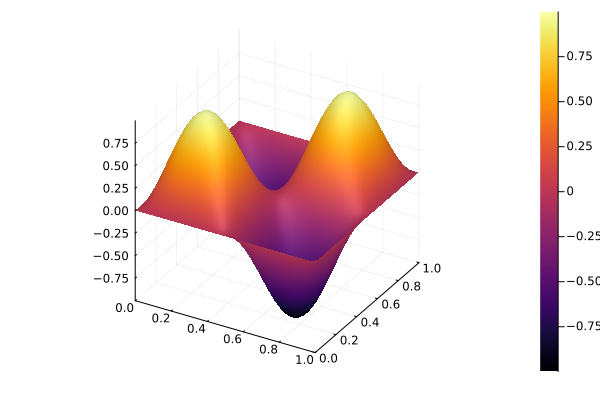

In [17]:
nt = 100
u_MMS = zeros(Dom.nx,Dom.ny,nt)
tarry = collect(range(0.0,t_f,step=Δt))
for j = 1:Dom.nx
    for i = 1:Dom.ny
        for k = 1:nt
            u_MMS[i,j,k] = ũ(Dom.gridx[i],Dom.gridy[j],tarry[k])
        end
    end
end

surface(Dom.gridy,Dom.gridx,u_MMS[:,:,end])

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191


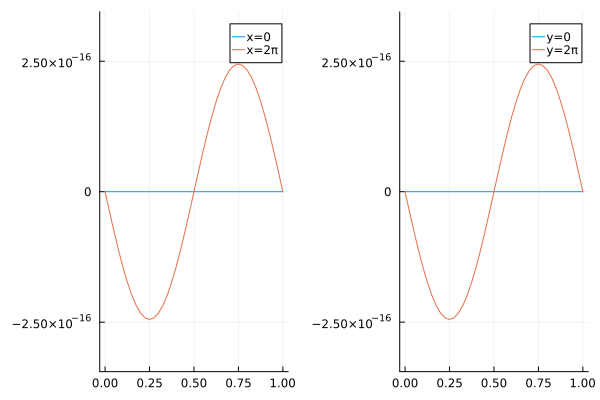

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Spiff\.julia\packages\PlotUtils\igbcf\src\ticks.jl:191


In [18]:
l = @layout [a b]
p = plot(Dom.gridy,u_MMS[1,:,end],layout=l,label="x=0")
plot!(p[1],Dom.gridy,u_MMS[end,:,end],label="x=2π")
plot!(p[2],Dom.gridx,u_MMS[:,1,end],label="y=0")
plot!(p[2],Dom.gridx,u_MMS[:,end,end],label="y=2π")

Create the PDE problem in `SBP_operators.jl` with the source term $\tilde{u}(x,y,t)$ so we are solving the PDE

$$
    \frac{\partial u}{\partial t} - K\Delta u = \tilde{u}
$$

In [19]:
# Diffusion coefficients
kx = ky = zeros(Float64,nx,ny) .+ 1.0;

# Boundary conditions from the MMS
BoundaryLeft = Boundary(Dirichlet,Bxũ,Left,1)
BoundaryRight = Boundary(Dirichlet,Bxũ,Right,1)
BoundaryUp = Boundary(Dirichlet,Byũ,Up,2)
BoundaryDown = Boundary(Dirichlet,Byũ,Down,2)

order = 2
method = :cgie

P = VariableCoefficientPDE2D(ũ₀,kx,ky,order,BoundaryLeft,BoundaryRight,BoundaryUp,BoundaryDown)


VariableCoefficientPDE2D{Float64}(ũ₀, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], 2, (Left = Boundary(SBP_operators.Helpers.BoundaryConditionType{:Dirichlet}(), Bxũ, SBP_operators.Helpers.NodeType{:Left, 1}(), 1), Right = Boundary(SBP_operators.Helpers.BoundaryConditionType{:Dirichlet}(), Bxũ, SBP_operators.Helpers.NodeType{:Right, 1}(), 1), Up = Boundary(SBP_operators.Helpers.BoundaryConditionType{:Dirichlet}(), Byũ, SBP_operators.Helpers.NodeType{:Left, 2}(), 2), Down = Boundary(SBP_operators.Helpers.BoundaryConditionType{:Dirichlet}(), Byũ, SBP_operators.Helpers.NodeType{:Right, 2}(), 2)))

Solve using the `SBP_operators.jl` package

In [20]:
soln = solve(P,Dom,Δt,t_f,:cgie,source=F)

SBP_operators.solvers.solution{Float64}(AbstractArray{Float64}[[0.0 0.0 … -0.0 -0.0; 0.0 0.024471741852423214 … -0.024471741852423252 -3.831539337756945e-17; … ; -0.0 -0.024471741852423252 … 0.024471741852423293 3.831539337756951e-17; -0.0 -3.831539337756945e-17 … 3.831539337756951e-17 5.99903913064743e-32], [0.0 0.0 … 0.0 0.0; 0.0 -0.17133684821135606 … 0.17133684821135614 -0.0006925362331692076; … ; 0.0 0.17133684821135617 … -0.17133684821135625 0.0008284714646990558; 0.0 -0.0006925362331692146 … 0.0008284714646990558 -4.866747181104084e-33]], Grid2D{Float64}([0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225  …  0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0], [0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225  …  0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0], 0.025, 0.025, 41, 41), [6.250000000000001e-5, 6.250000000000001e-5], [0.0, 0.006250000000000005], VariableCoefficientPDE2D{Float64}(ũ₀, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;

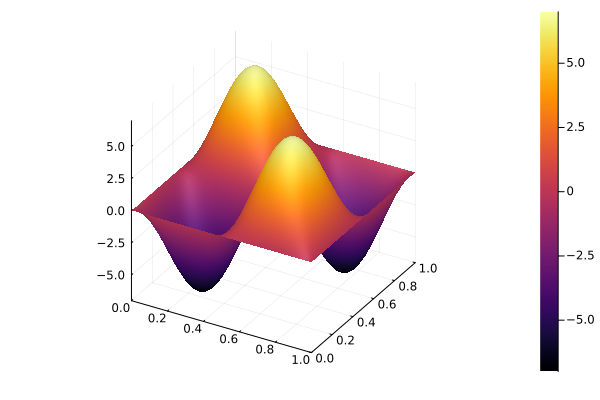

In [21]:
surface(Dom.gridy,Dom.gridx,soln.u[2])